# Imports

In [10]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math
import time
from PIL import Image
from scipy import fftpack

# Função de DCT-2D

## Transformada Cosseno Discreta (DCT)

In [11]:
def DCT_1D(data):
    N = len(data)
    X = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for k in range(N):
        if (k == 0):
            ck = math.sqrt(1.0/2.0) 
        else:
            ck = 1
        s = 0
        for n in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            s += data[n] * math.cos((a1/nn) + (a2/nn))
        X[k] = aK * ck * s
    return X

## Transformada DCT inversa (IDCT)

In [12]:
def IDCT_1D(data):
    N = len(data)
    x = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for n in range(N):
        s = 0
        for k in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            if (k == 0):
                ck = math.sqrt(1.0/2.0)
            else:
                ck = 1  
            s += ck * data[k] * math.cos((a1/nn) + (a2/nn))
        x[n] = aK * s
    return x

### Verificação de DCT & IDCT

In [39]:
array_test = np.array([4.25, 0.08993, 12.5789, -1.87, -325, 2021.2])

X_DCT_1D = DCT_1D(array_test)

X_IDCT_1D = IDCT_1D(X_DCT_1D)

print ("-> Validação das transformadas:")
if(X_IDCT_1D.all() == array_test.all()):
    print("O resultado obtido pela inversa é equivalente aos dados de entrada.")
else:
    print("Houve um erro na trasformação")
    
print ("\nDados de Entrada:")
print([ "{:0.2f}".format(x) for x in array_test ])

print ("\nAplicação da DCT_1D:")
print([ "{:0.2f}".format(x) for x in X_DCT_1D ])

print ("\nAplicação da IDCT_1D:")
print([ "{:0.2f}".format(x) for x in X_IDCT_1D ])

-> Validação das transformadas:
O resultado obtido pela inversa é equivalente aos dados de entrada.

Dados de Entrada:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']

Aplicação da DCT_1D:
['698.61', '-989.93', '1007.37', '-962.03', '775.38', '-426.05']

Aplicação da IDCT_1D:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']


## Funções auxiliares

In [52]:
def readImageByPath(path):
    imagem = Image.open(path)
    imagem = np.asarray(imagem)
    plt.imshow(imagem, cmap="gray")
    plt.title(path[6:])
    plt.show()
    return imagem

In [53]:
def readVideoByPath(path):
    portion_slice = 2000
    base = 20000
    audio_rate, audio_data = wavfile.read(path)
    # audio_portion = audio_data[base:base+portion_slice]
    audio_portion = audio_data
    audio_data.shape
    #return

In [54]:
def printAudio(data):
    plt.figure('Data', figsize=[20,6])
    plt.plot(data, linewidth=0.5,alpha=1,color="blue")
    plt.title("Audio")
    plt.ylabel("Amplitude")
    plt.show()

## Questão 01

#### 1.1 Exibir o módulo normalizado da DCT de I, sem o nível DC, e o valor (numérico) do nível DC

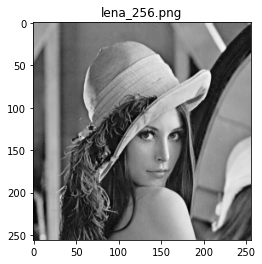

In [74]:
img_input_256 = readImageByPath ("utils/lena_256.png")

In [75]:
#img_input_256 = readImageByPath ("utils/lena.bmp")

### Aplicação de DCT 2D

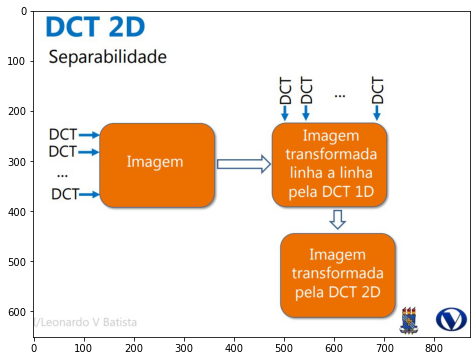

In [76]:
DCT2D_image_slide = Image.open("utils/DCT2D.jpg")
plt.figure(figsize=[60,6])
plt.imshow(DCT2D_image_slide)

In [86]:
imgDCT             = np.zeros(img_input_256.shape)
img_DCT_horizontal = np.zeros(img_input_256.shape)
img_DCT_vertical   = np.zeros(img_input_256.shape)

inicio = time.time()

#DCT nas linhas - horizontal
for i, linha in enumerate(img_input_256): 
    img_DCT_horizontal[i] = DCT_1D(linha)
    
#Transposição dos dados
img_input_vertical = img_DCT_horizontal.T

#DCT nas colunas - vertical
for i, linha in enumerate(img_input_vertical):
    img_DCT_vertical[i] = DCT_1D(linha)

fim = time.time()
print("Tempo de execução: {} segundos".format((fim - inicio)))

Tempo de execução: 88.85733985900879 segundos


### Nível de DC

In [87]:
imgDCT = img_DCT_vertical.T
img_dc = imgDCT[0][0]
print("Nivel DC: {}".format(imgDCT[0][0]))

Nivel DC: 31883.60937500001


Text(0.5, 1.0, 'Com DC')

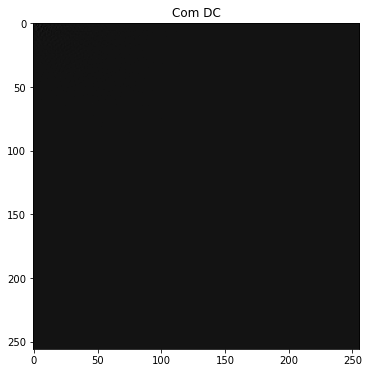

In [88]:
plt.figure(figsize=[60,6])
plt.imshow(imgDCT, cmap="gray")
plt.title("Com DC")

Text(0.5, 1.0, 'SEM DC')

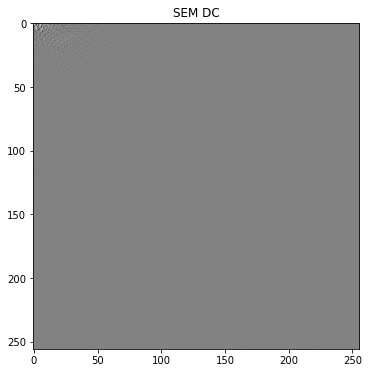

In [89]:
imgDCT[0][0] = 0
plt.figure(figsize=[60,6])
plt.imshow(imgDCT, cmap="gray")
plt.title("SEM DC")

### Módulo normalizado da DCT

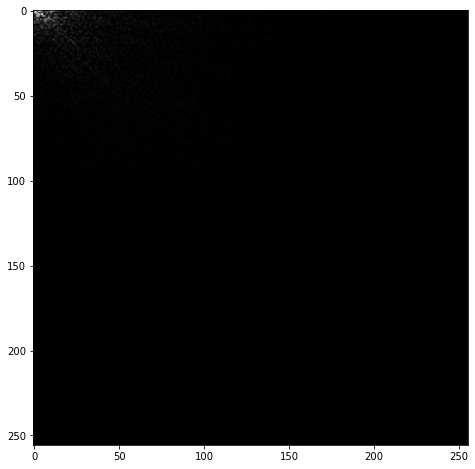

In [90]:
norm_img = imgDCT.copy()

for i in range(norm_img.shape[0]):
    for j in range(norm_img.shape[1]):
        norm_img[i][j] = abs(norm_img[i][j])

plt.figure(figsize=[80,8])
plt.imshow(norm_img, cmap="gray")

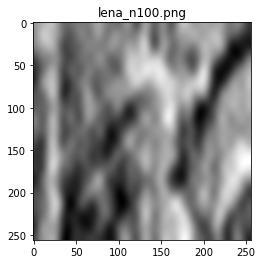

In [45]:
image_n100 = readImageByPath ("utils/lena_n100.png")

Dada uma imagem I em níveis de cinza, de dimensões RxC, desenvolva um programa para:

1.1 Exibir o módulo normalizado da DCT de I, sem o nível DC, e o valor (numérico) do nível DC

1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].

In [ ]:
imagem = Image.open("utils/lena.bmp")
imagem = np.asarray(imagem)

#### 1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].